# DIVI Intensivregister

## What are we dealing with?
It's a php-generated page containing a table which lists many (not all?) German clinics in a column labeled `Klinikname`. Other columns are labeled *Kontakt* = contact info, *Bundesland* = federal state, [*ICU*](https://en.wikipedia.org/wiki/Intensive_care_unit) *low care*, *ICU high care*, [*ECMO*](https://en.wikipedia.org/wiki/Extracorporeal_membrane_oxygenation) and *Stand* = time stamp. The columns *ICU* and *ECMO* solely contain colored bubbles to illustrate the availability of these resources. The legends explains as follows:

* red = *Verfügbar* = ready
* yellow = *Begrenzt* = limited
* green = *Ausgelastet* = exhausted
* unavailable = unknown state

A form offers sorting and filtering of that table.

## What to contribute?
The table only shows contemporary data as clinics submit their data (time stamp!). Aside to some statistics on that data -- what might be interesting to see is how it develops over time during the [COVID19](https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic) pandemic.

# Approach

## Fetch data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scrape import scrape, divi

In [2]:
scrape_result = divi.to_dataframe(mapping=lambda x: x)
scrape_result

,Klinikname,Kontakt,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,Kreisklinik Trostberg,Intensivstation Website,BY,red,green,unavailable,2020-04-03 10:39:00
1,Herzogparkklinik Arabellaklinik,Intensivstation Website,BY,green,yellow,unavailable,2020-04-03 10:45:00
2,Klinikum Werra Meißner Standorte Eschwege / Wi...,ITS Website,HE,green,green,unavailable,2020-04-03 10:34:00
3,"Knappschaftsklinikum Saar GmbH, Krankenhaus Su...",Website,SL,green,green,unavailable,2020-04-03 10:13:00
4,"Knappschaftsklinikum Saar GmbH, Krankenhaus Pü...",Website,SL,green,green,unavailable,2020-04-03 10:11:00
...,...,...,...,...,...,...,...
1066,Universitätsklinikum Erlangen,Koordination Website,BY,green,green,green,2020-04-03 07:39:00
1067,Universitätsklinikum Bonn,Operative Intensivmedizin Website,NRW,red,red,red,2020-04-02 10:37:00
1068,Helios Klinikum Bad Saarow,"ITS 1, ITS 2, ITS 3 Website",BB,red,green,green,2020-04-03 10:10:00
1069,Elisabeth-Krankenhaus Essen,kardiologisch- internistische Intensivstation ...,NRW,green,green,green,2020-04-02 18:25:00


In [3]:
scrape_result.describe()

,Klinikname,Kontakt,Bundesland,ICU low care,ICU high care,ECMO,Stand
count,1071,1071,1071,1071,1071,1071,1071
unique,1049,416,16,3,3,4,751
top,St. Marienhospital Vechta gGmbH,Intensivstation Website,NRW,green,green,unavailable,2020-04-03 08:32:00
freq,2,211,270,775,824,860,6
first,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-20 09:26:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-03 10:45:00


Apparently, *St. Marienhospital Vechta gGmbH* has got a double entry.

## Raw data
Next, let's deduplicate and drop the contact info. Additionally, say the colors describe some kind of stress signal, turn colors into float values (red being high and green being low):

|  color        |  float  |
|:--------------|:-------:|
|  red          |   0.0   |
|  yellow       |   0.5   |
|  green        |   1.0   |
|  unavailable  |   NAN   |

In [4]:
df = scrape_result \
.drop_duplicates() \
.drop('Kontakt', axis=1) \
.replace({'green': 0.0, 'yellow': 0.5, 'red': 1.0, 'unavailable': np.nan})
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,Kreisklinik Trostberg,BY,1.0,0.0,NaN,2020-04-03 10:39:00
1,Herzogparkklinik Arabellaklinik,BY,0.0,0.5,NaN,2020-04-03 10:45:00
2,Klinikum Werra Meißner Standorte Eschwege / Wi...,HE,0.0,0.0,NaN,2020-04-03 10:34:00
3,"Knappschaftsklinikum Saar GmbH, Krankenhaus Su...",SL,0.0,0.0,NaN,2020-04-03 10:13:00
4,"Knappschaftsklinikum Saar GmbH, Krankenhaus Pü...",SL,0.0,0.0,NaN,2020-04-03 10:11:00
...,...,...,...,...,...,...
1066,Universitätsklinikum Erlangen,BY,0.0,0.0,0.0,2020-04-03 07:39:00
1067,Universitätsklinikum Bonn,NRW,1.0,1.0,1.0,2020-04-02 10:37:00
1068,Helios Klinikum Bad Saarow,BB,1.0,0.0,0.0,2020-04-03 10:10:00
1069,Elisabeth-Krankenhaus Essen,NRW,0.0,0.0,0.0,2020-04-02 18:25:00


In [5]:
df.describe()

,ICU low care,ICU high care,ECMO
count,1071.000000,1071.000000,211.000000
mean,0.197479,0.155462,0.244076
std,0.345171,0.306267,0.379097
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.500000,0.000000,0.500000
max,1.000000,1.000000,1.000000


## Cleanup
How does the data contribution spread over time?

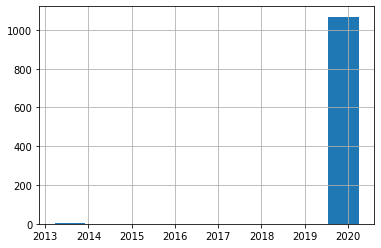

In [6]:
df.describe()
df['Stand'].hist()

Clean this up a bit: remove pre 19/20 contributions.

(array([737501., 737503., 737505., 737507., 737509., 737511., 737513.,
        737515., 737516., 737518.]),
 <a list of 10 Text major ticklabel objects>)

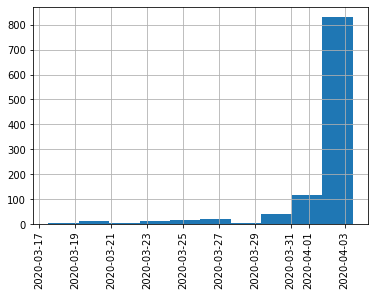

In [7]:
from datetime import datetime
df = df[(df['Stand'] > '2019-12-31') & (df['Stand'] <= datetime.now())]
df['Stand'].hist()
plt.xticks(rotation=90)

Better! Most contributions have been made recently, that's good.

## Plot average values (per federal state)

Text(0, 0.5, 'federal state')

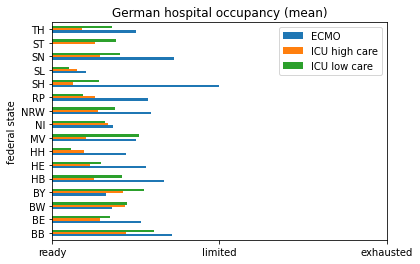

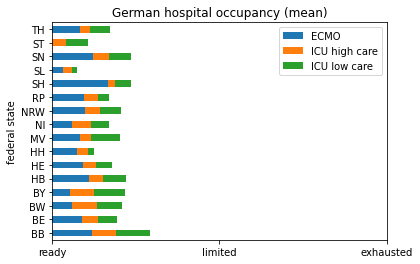

In [8]:
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=False)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 0.5, 1.0],["ready", "limited", "exhausted"])
plt.ylabel("federal state")
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=True)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 1.5, 3.0],["ready", "limited", "exhausted"]) # 3x[0..1] = [0..3]
plt.ylabel("federal state")

So much for contemporary data.

# Historic data
Instead of downloading the data from DIVI we are going to use the old scrapes in `data/divi.tsv`:

In [9]:
#!git pull 2&>1 >/dev/null
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scrape import scrape, divi
df = pd \
.read_csv("data/divi.tsv", sep="\t", index_col=0, parse_dates=True) \
.drop_duplicates() \
.drop('Kontakt', axis=1)
df['Stand'] = pd.to_datetime(df['Stand'])
df = df[(df['Stand'] > '2019-12-31') & (df['Stand'] <= datetime.now())]
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,"AMEOS Klinik ""Am Bürgerpark"" Bremerhaven",HB,1.0,1.0,NaN,2020-04-02 21:34:00
1,Klinikum Traunstein,BY,1.0,0.5,NaN,2020-04-02 20:46:00
2,AMEOS Klinikum Mitte Bremerhaven,HB,1.0,1.0,NaN,2020-04-02 20:26:00
3,Uniklinik RWTH Aachen - Interdisziplinäre Inte...,NRW,0.5,1.0,1.0,2020-04-02 19:55:00
4,Heliosklinik Lengerich,NRW,0.0,1.0,NaN,2020-04-02 19:14:00
...,...,...,...,...,...,...
7892,Universitätsklinikum Dresden,SN,1.0,1.0,1.0,2020-03-24 14:25:00
7893,Universitätsklinikum Erlangen,BY,1.0,1.0,1.0,2020-03-24 08:27:00
7894,Universitätsklinikum Bonn,NRW,1.0,1.0,1.0,2020-03-22 15:55:00
7895,Helios Klinikum Bad Saarow,BB,0.5,1.0,1.0,2020-03-24 07:15:00


In [13]:
import matplotlib.dates as mdates
from scrape import entorb

federal_state_translation = {
    "BB": "Brandenburg",
    "BE": "Berlin",
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "HB": "Bremen",
    "HE": "Hessen",
    "HH": "Hamburg",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SH": "Schleswig-Holstein",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "TH": "Thüringen",
}

columns = ['ICU low care', 'ICU high care', 'ECMO']
federal_states = list(set(df['Bundesland']))
exhaustion = dict()
num_clinics = dict()

# plot each bundesland's total exhaustion
# but also keep each curve in dict bundesland_curves for later correlations
for federal_state in federal_state_translation:
    if federal_state == "0":
        continue
    
    clinics_curves_sum = None
    federal_state_clinics = list(set(df[df['Bundesland'] == federal_state]['Klinikname']))
    
    # One clinic enters "0" as their bundesland but is actually situated in NRW
    if federal_state == "NW":
        appendix = list(set(df[df['Bundesland'] == "0"]['Klinikname']))
        federal_state_clinics = list(set(federal_state_clinics + appendix))
        appendix = list(set(df[df['Bundesland'] == "NRW"]['Klinikname']))
        federal_state_clinics = list(set(federal_state_clinics + appendix))
    
    # apply padding to each clinic's curve
    for clinic in federal_state_clinics:
        # use resample() here because we want to correlate day-by-day later
        clinic_curve = df[df['Klinikname'] == clinic] \
        .set_index('Stand') \
        .drop(columns=['Bundesland', 'Klinikname']) \
        .resample("1D").sum() \
        .fillna(method="pad")
        # TODO .cumsum() useful here?

        # is there something less clumsy from pandas?
        if clinics_curves_sum is None:
            clinics_curves_sum = clinic_curve
        else:
            clinics_curves_sum = clinics_curves_sum.add(clinic_curve, fill_value=0)
    
    exhaustion[federal_state] = clinics_curves_sum
    num_clinics[federal_state] = len(federal_state_clinics)

In [49]:
infections = dict()
deaths = dict()
for federal_state in federal_state_translation:
    infections[federal_state] = entorb.to_dataframe("NW" if federal_state in ['NRW', '0'] else federal_state)['new infections']
    deaths[federal_state] = entorb.to_dataframe("NW" if federal_state in ['NRW', '0'] else federal_state)['new deaths']

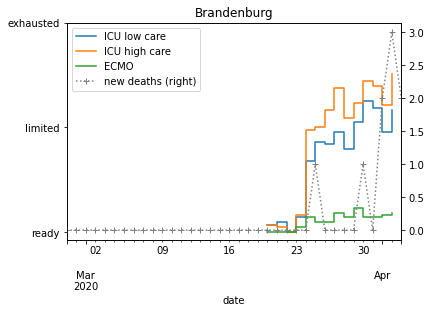

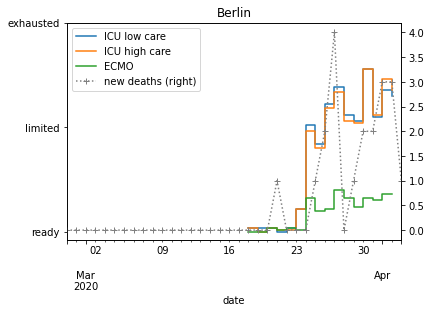

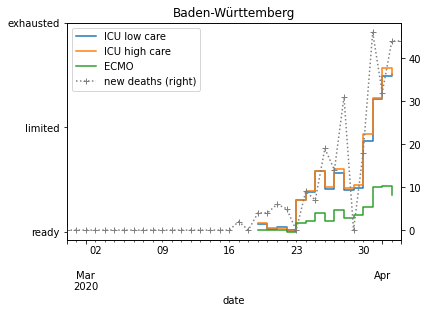

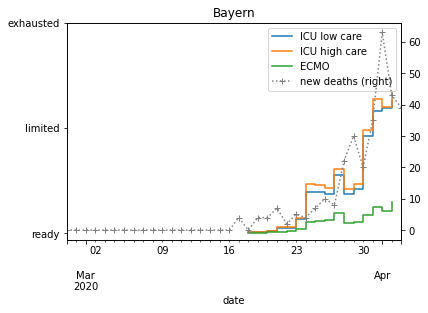

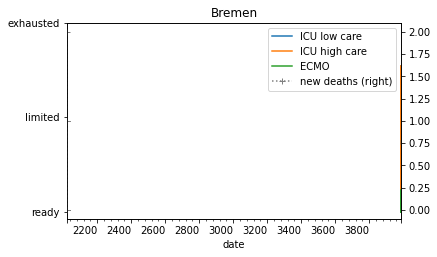

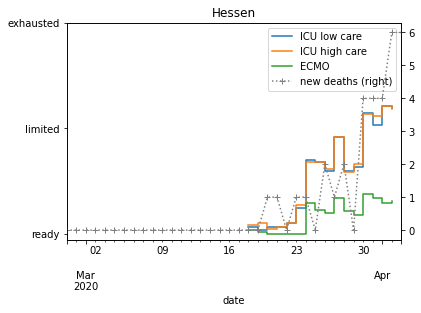

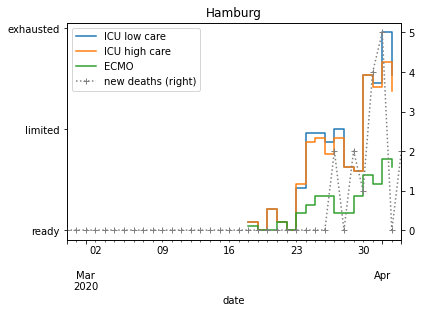

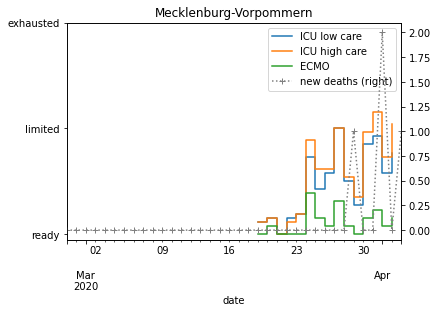

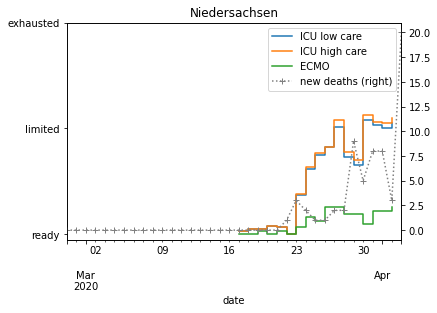

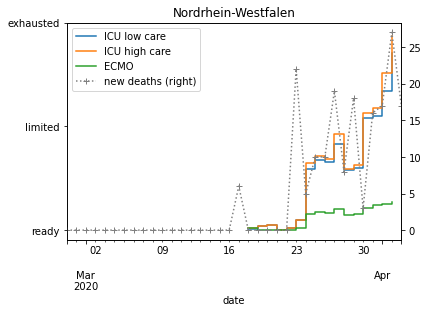

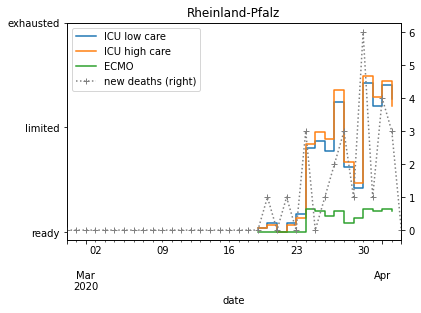

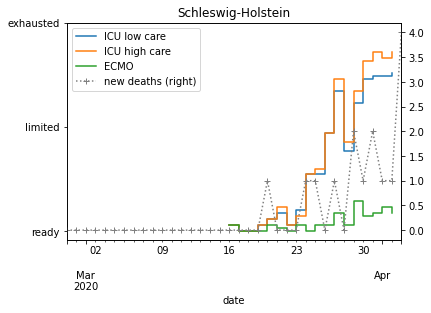

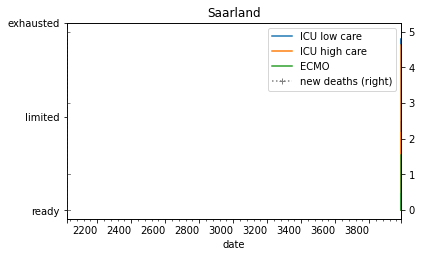

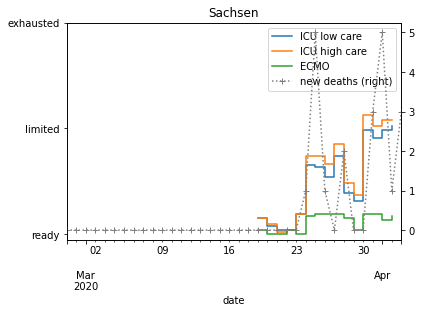

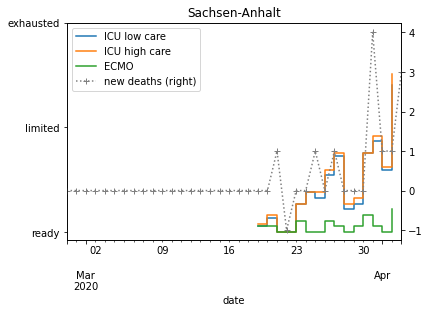

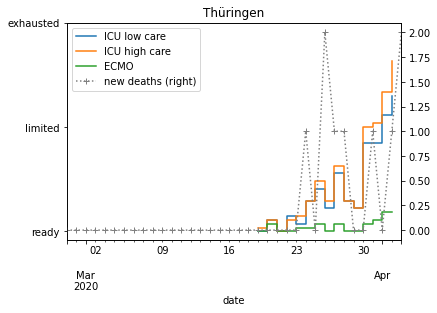

In [56]:
for federal_state in federal_state_translation:
    exhaustion[federal_state].plot(kind='line', drawstyle='steps-post', y=columns, marker='')
    plt.yticks([0.0 * num_clinics[federal_state], 0.5 * num_clinics[federal_state], 1.0 * num_clinics[federal_state]],
               ["ready", "limited", "exhausted"])
    
    deaths[federal_state].plot(kind='line', secondary_y=True, color='grey', linestyle=':', marker='+', legend=True)
    #infections[federal_state].plot(kind='line', secondary_y=True, color='red', linestyle='-', marker='')
    
    plt.title("%s" % federal_state_translation[federal_state])